In [1]:
using DifferentialEquations
using LinearAlgebra
using Plots

include("../model/Plant.jl")

Main.Plant

In [10]:
state = Plant.State()
u0 = [state.x, state.y, state.n, state.h, state.Ca, state.V, state.Isyn]

7-element Vector{Float64}:
   0.7
   5.472e-46
   0.137
   0.389
   0.8
 -62.0
   0.0

# Spike counting
Naively it seems that one should be able to delimit bursts by testing for local minima in `Ca`. However, this turns out not to work, as `Ca` does not always increase monotonically during spikes. [One solution can be found here.](https://juliadynamics.github.io/DynamicalSystems.jl/dev/chaos/basins/#ChaosTools.AttractorsViaRecurrences)

Another way to do this is as follows. Select arbitrary initial conditions and an initial set of parameters, integrate a long trajectory. Then set the initial conditions to the final point in the trajectory. Keep these initial conditions and do a sweep throughout a region of parameter space. Test at each parameter value for the minimal locally minimal distance to the initial point for each trajectory; compare to a threshold value. If exceeding, set the initial conditions to the final point in that trajectory, discard the first trajectory, and perform another integration.

This may be more expensive than just discarding initial transients always, with a single fixed initial condition. If we do choose to always discard initial transients, there should be a way to determine what the threshold `x` value ought to be.

There is another way to detect bursts, but with a state machine. Detect the following sequence of events:
1. $[Ca]$ increasing, $x$ local maximum.
2. $x$ decreasing, $[Ca]$ local maximum.
3. $[Ca]$ decreasing, $x$ local minimum.
4. $x$ increasing, $[Ca]$ local minimum.

In fact it may even work just to test for the last two events.

I should look at event handling / callback functions in the DifferentialEquations.jl and DiffEqGPU.jl libraries to see how to manage this state machine during integration rather than recomputing critical points for the whole trajectory after integration, which is likely slower.

In [64]:
function countSpikes(sol)
    # Obtain burst reset times.
    resets = []
    for i in 3:length(sol)
        # Detect a local minimum in calcium concentration wherein x variable is increasing.
        if sol[i-1][5] < sol[i-2][5] && sol[i-1][5] < sol[i][5] && sol[i][1] > sol[i-1][1] > sol[i-2][1]
            push!(resets, i)
        end
    end

    #print("$(length(resets)) burst resets observed.")

    V_threshold = 0.0

    # Obtain spike counts per burst.
    spike_counts = []
    for i in 1:length(resets)-1
        spike_count = 0
        for j in resets[i]:resets[i+1]
            if sol[j-1][6] < V_threshold < sol[j][6]
                spike_count += 1
            end
        end
        push!(spike_counts, spike_count)
    end

    if spike_counts == []
        return [0]
    else
        return spike_counts
    end
end

countSpikes (generic function with 1 method)

In [65]:
function transitionMap(spike_counts)
    plt = scatter(1, markeralpha=0.2, legend=false)
    for i in 1:length(spike_counts)-1
        push!(plt, (spike_counts[i], spike_counts[i+1]))
    end
    return plt
end

transitionMap (generic function with 1 method)

In [66]:
function markovChain(spike_counts)
    if length(spike_counts) == 0
        return zeros(0, 0)
    end
    size = max(spike_counts...)
    if size == 0
        return zeros(0, 0)
    end
    rows = []
    for i in 0:size
        row = zeros(size+1)
        for j in 1:length(spike_counts)-1
            if spike_counts[j] == i
                row[spike_counts[j+1]+1] += 1
            end
        end
        if sum(row) == 0
            push!(rows, row)
        else
            push!(rows, row/sum(row))
        end
    end
    return reduce(vcat, transpose.(rows))
end

markovChain (generic function with 1 method)

In [67]:
function melibeNewHelper!(du, u, p, t)
    θ = Plant.Params(
        Cₘ   = p[1],
        gI   = p[2],
        gK   = p[3],
        gₕ   = p[4],
        gL   = p[5],
        gT   = p[6],
        gKCa = p[7],
        EI   = p[8],
        EK   = p[9],
        Eₕ   = p[10],
        EL   = p[11],
        ECa  = p[12],
        Kc   = p[13],
        τₓ   = p[14],
        ρ    = p[15],
        Δx   = p[16],
        ΔCa  = p[17]
    )
    Plant.melibeNew!(du, u, θ, t)
end

melibeNewHelper! (generic function with 1 method)

In [68]:
using Statistics

In [71]:
ΔCa_length = 600
Δx_length = 300

range_ΔCa = range(-77.5, 0, length=ΔCa_length)
range_Δx = range(-2.75, 18, length=Δx_length)
params = []
for ΔCa in range_ΔCa
    for Δx in range_Δx
        θ = Plant.Params(
            ΔCa = ΔCa,
            Δx = Δx
        )
        p = [
            θ.Cₘ,
            θ.gI,
            θ.gK,
            θ.gₕ,
            θ.gL,
            θ.gT,
            θ.gKCa,
            θ.EI,
            θ.EK,
            θ.Eₕ,
            θ.EL,
            θ.ECa,
            θ.Kc,
            θ.τₓ,
            θ.ρ,
            θ.Δx,
            θ.ΔCa
        ]
        push!(params, p)
    end
end

tspan = (0, 1e4)

(0, 10000.0)

In [72]:
prob = ODEProblem(melibeNewHelper!, u0, tspan, params[1])
prob_func(prob, i, repeat) = remake(prob, p=params[trunc(Int, i)]) # Why are we getting Floats here?
function output_func(sol, i)
    spike_counts = countSpikes(sol)
    if length(spike_counts) < 2
        return (-Inf, false)
    else
        return (log(var(spike_counts)), false)
    end
end
monteprob = EnsembleProblem(prob, output_func=output_func, prob_func=prob_func, safetycopy=false)
sol = solve(monteprob, Tsit5(), EnsembleThreads(), trajectories=ΔCa_length*Δx_length, verbose=false);

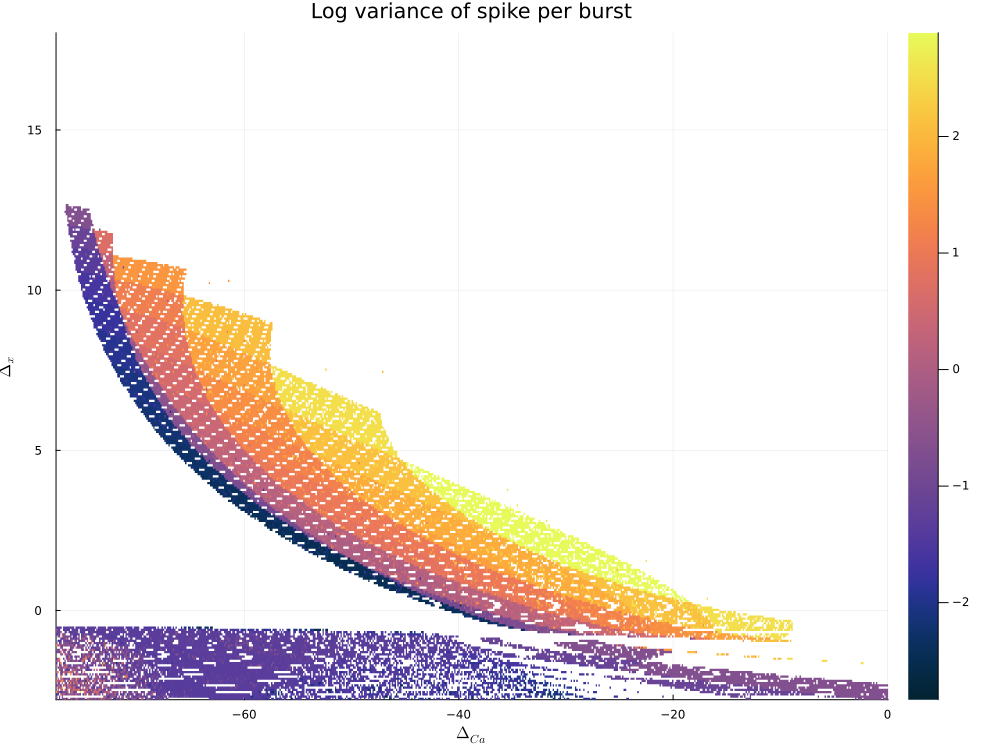

In [73]:
heatmap(range_ΔCa, range_Δx, reshape(sol, (Δx_length, ΔCa_length)), xlabel="\$Δ_{Ca}\$", ylabel="\$Δ_x\$", color=:thermal, title="Log variance of spike per burst", size=(1000, 750), dpi=1000)

In [51]:
sol_matrix = reshape(sol, (Δx_length, ΔCa_length))

300×600 reshape(::EnsembleSolution{Real, 1, Vector{Real}}, 300, 600) with eltype Real:
 -2.19983  -1.53494   -1.59059   …  -Inf  -Inf  -Inf  -Inf  -Inf  0  0
 -1.24223  -1.64376   -1.44407        0   -Inf  -Inf    0     0   0  0
 -2.07515  -1.56204   -1.48022      -Inf    0     0     0     0   0  0
 -1.96275  -1.51991   -1.62714        0     0     0     0     0   0  0
 -1.73411  -0.972732  -1.26449        0     0     0     0     0   0  0
 -1.82146  -1.4899    -1.3622    …    0     0     0     0     0   0  0
 -2.03404  -1.26155   -1.23353        0     0     0     0     0   0  0
 -1.70339  -1.66093   -1.70618        0     0     0     0     0   0  0
 -1.50168  -1.75929   -1.52218        0     0     0     0     0   0  0
 -1.64457  -1.19779   -1.18518        0     0     0     0     0   0  0
 -1.98094  -1.56971   -1.26449   …    0     0     0     0     0   0  0
 -1.70035  -1.65751   -0.951455       0     0     0     0     0   0  0
 -1.26491  -1.8351    -1.36164        0     0     0     0    